In [1]:
#Step 1: Importing Required Libraries
import numpy as np
import pandas as pd
from gensim.models import Word2Vec, FastText
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# here we can aslo just import the above as `from sklearn import metrics` which import the whole metrics module 
# with all its functions instead of its specific functions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
#Step 2: Impoting Dataset, Here we are using Stanford Sentiment Treebank 2 Dataset
splits = {'train': 'data/train-00000-of-00001.parquet', 
          'validation': 'data/validation-00000-of-00001.parquet', 
          'test': 'data/test-00000-of-00001.parquet'}
sst_df_train = pd.read_parquet("datasets/sst2/" + splits["train"])
sst_df_test = pd.read_parquet("datasets/sst2/" + splits["test"])
sst_df_val = pd.read_parquet("datasets/sst2/" + splits["validation"])
sst_df_train

,idx,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...,...
67344,67344,a delightful comedy,1
67345,67345,"anguish , anger and frustration",0
67346,67346,"at achieving the modest , crowd-pleasing goals...",1
67347,67347,a patient viewer,1


## Stanford Sentiment Treebank (SST2)

The **Stanford Sentiment Treebank (SST2)** is a dataset designed for sentiment analysis tasks. It contains 11,855 single sentences extracted from movie reviews, annotated with sentiment labels. The dataset is a binary classification task where sentences are labeled as either **negative** (0) or **positive** (1). 

### Key Features:
- **Sentences**: 11,855
- **Labels**: 
  - Negative (0)
  - Positive (1)
- **Data Source**: Movie reviews
- **Usage**: Commonly used for training and evaluating sentiment analysis models.

### Data Structure:
Each entry in the dataset consists of:
- `sentence`: The text of the movie review.
- `label`: The sentiment label associated with the sentence.

### Splits:
The dataset typically includes training, validation, and test splits to facilitate model evaluation.

### Applications:
SST2 is widely used in natural language processing research and serves as a benchmark for various sentiment classification algorithms.

In [3]:
sst_df_test

,idx,sentence,label
0,0,uneasy mishmash of styles and genres .,-1
1,1,this film 's relationship to actual tension is...,-1
2,2,"by the end of no such thing the audience , lik...",-1
3,3,director rob marshall went out gunning to make...,-1
4,4,lathan and diggs have considerable personal ch...,-1
...,...,...,...
1816,1816,"it risks seeming slow and pretentious , becaus...",-1
1817,1817,take care of my cat offers a refreshingly diff...,-1
1818,1818,davis has filled out his cast with appealing f...,-1
1819,1819,it represents better-than-average movie-making...,-1


In [4]:
# Adjust labels in the test set (if necessary)
sst_df_test['label'] = sst_df_test['label'].replace({-1: 0, 1: 1})
sst_df_test

,idx,sentence,label
0,0,uneasy mishmash of styles and genres .,0
1,1,this film 's relationship to actual tension is...,0
2,2,"by the end of no such thing the audience , lik...",0
3,3,director rob marshall went out gunning to make...,0
4,4,lathan and diggs have considerable personal ch...,0
...,...,...,...
1816,1816,"it risks seeming slow and pretentious , becaus...",0
1817,1817,take care of my cat offers a refreshingly diff...,0
1818,1818,davis has filled out his cast with appealing f...,0
1819,1819,it represents better-than-average movie-making...,0


In [5]:
sst_df_val

,idx,sentence,label
0,0,it 's a charming and often affecting journey .,1
1,1,unflinchingly bleak and desperate,0
2,2,allows us to hope that nolan is poised to emba...,1
3,3,"the acting , costumes , music , cinematography...",1
4,4,"it 's slow -- very , very slow .",0
...,...,...,...
867,867,has all the depth of a wading pool .,0
868,868,a movie with a real anarchic flair .,1
869,869,a subject like this should inspire reaction in...,0
870,870,... is an arthritic attempt at directing by ca...,0


In [6]:
# Creating a copy of datafames to be used in Word2Vec
sst_word2vec_df_train=pd.DataFrame(sst_df_train)
sst_word2vec_df_test=pd.DataFrame(sst_df_test)
sst_word2vec_df_val=pd.DataFrame(sst_df_val)

In [7]:
sst_word2vec_df_test

,idx,sentence,label
0,0,uneasy mishmash of styles and genres .,0
1,1,this film 's relationship to actual tension is...,0
2,2,"by the end of no such thing the audience , lik...",0
3,3,director rob marshall went out gunning to make...,0
4,4,lathan and diggs have considerable personal ch...,0
...,...,...,...
1816,1816,"it risks seeming slow and pretentious , becaus...",0
1817,1817,take care of my cat offers a refreshingly diff...,0
1818,1818,davis has filled out his cast with appealing f...,0
1819,1819,it represents better-than-average movie-making...,0


In [8]:
# Tokenization and lowercasing for training data
sst_word2vec_df_train['sentence'] = sst_word2vec_df_train['sentence'].apply(lambda x: x.lower().split())
sst_word2vec_df_val['sentence'] = sst_word2vec_df_val['sentence'].apply(lambda x: x.lower().split())
sst_word2vec_df_test['sentence'] = sst_word2vec_df_test['sentence'].apply(lambda x: x.lower().split())

In [9]:
sst_word2vec_df_train

,idx,sentence,label
0,0,"[hide, new, secretions, from, the, parental, u...",0
1,1,"[contains, no, wit, ,, only, labored, gags]",0
2,2,"[that, loves, its, characters, and, communicat...",1
3,3,"[remains, utterly, satisfied, to, remain, the,...",0
4,4,"[on, the, worst, revenge-of-the-nerds, clichés...",0
...,...,...,...
67344,67344,"[a, delightful, comedy]",1
67345,67345,"[anguish, ,, anger, and, frustration]",0
67346,67346,"[at, achieving, the, modest, ,, crowd-pleasing...",1
67347,67347,"[a, patient, viewer]",1


## 1. Word2Vec

In [10]:
# Train a Word2Vec model on the training sentences
word2vec_model = Word2Vec(sentences=sst_word2vec_df_train['sentence'], vector_size=100, window=5, min_count=1, workers=4)

# Example of getting a vector for a word (optional)
word_vector = word2vec_model.wv['risks']  # Replace 'risks' with any word in your dataset
print(word_vector)

[-0.04933172  0.11031395  0.04526384  0.00047584 -0.00827894 -0.10987838
 -0.00208221  0.1786304  -0.05769502 -0.07466732  0.02547914 -0.11817035
 -0.04311824 -0.00404335  0.02626322 -0.03645671  0.07248522 -0.04125851
 -0.03679681 -0.18155777  0.05642984 -0.01839122  0.12926629 -0.06640902
 -0.02555102  0.06233253 -0.07495719 -0.02060423 -0.1053853   0.05501481
  0.07596803 -0.00437624  0.07061203 -0.12013289 -0.01576231  0.05670581
  0.02742136 -0.05130351 -0.06927042 -0.14912045  0.01133712 -0.05278876
 -0.06128582  0.04162407  0.06711989 -0.04246452 -0.09575955 -0.070294
  0.06481946  0.05866391  0.01959872 -0.05820773  0.00355092 -0.1152381
 -0.07381132  0.01955243  0.01847329  0.00025301 -0.05988537  0.07675087
  0.05372843 -0.01523125 -0.01013785  0.05952853 -0.06463469  0.14442702
  0.04305502  0.10277202 -0.1477983   0.07673109 -0.06978782  0.02792885
  0.10983616  0.06059513  0.11287121 -0.00175203  0.03486842 -0.01168799
 -0.06385909 -0.06632806 -0.08883946 -0.04841856 -0.01

In [11]:
# Train a Word2Vec model on the training sentences
word2vec_model = Word2Vec(sentences=sst_word2vec_df_train['sentence'], vector_size=100, window=5, min_count=1, workers=4)

# Function to get sentence embeddings by averaging word vectors
def get_sentence_vector(sentence):
    # Filter out words not in the vocabulary
    word_vectors = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(word2vec_model.vector_size)

# Get Word2Vec embeddings for each sentence in training, validation, and test sets
sst_word2vec_df_train['word2vec_embedding'] = sst_word2vec_df_train['sentence'].apply(get_sentence_vector)
sst_word2vec_df_val['word2vec_embedding'] = sst_word2vec_df_val['sentence'].apply(get_sentence_vector)
sst_word2vec_df_test['word2vec_embedding'] = sst_word2vec_df_test['sentence'].apply(get_sentence_vector)

In [12]:
sst_word2vec_df_train

,idx,sentence,label,word2vec_embedding
0,0,"[hide, new, secretions, from, the, parental, u...",0,"[-0.07686861, 0.28996092, 0.08085586, -0.13063..."
1,1,"[contains, no, wit, ,, only, labored, gags]",0,"[0.14492129, 0.26936415, -0.16523851, 0.400797..."
2,2,"[that, loves, its, characters, and, communicat...",1,"[-0.15368174, 0.2722683, -0.5040707, 0.0731539..."
3,3,"[remains, utterly, satisfied, to, remain, the,...",0,"[0.30119985, 0.35984367, -0.016400972, -0.1148..."
4,4,"[on, the, worst, revenge-of-the-nerds, clichés...",0,"[0.37619603, 0.096211694, -0.108461976, -0.478..."
...,...,...,...,...
67344,67344,"[a, delightful, comedy]",1,"[-0.66316473, 1.0022528, 0.14133011, 0.1557445..."
67345,67345,"[anguish, ,, anger, and, frustration]",0,"[-0.43389136, 0.3333399, 0.026535729, 0.240289..."
67346,67346,"[at, achieving, the, modest, ,, crowd-pleasing...",1,"[0.42759055, -0.15149726, -0.11698816, -0.0548..."
67347,67347,"[a, patient, viewer]",1,"[0.1608256, 0.35729742, -0.2816789, -0.2888191..."


In [13]:
sst_word2vec_df_test

,idx,sentence,label,word2vec_embedding
0,0,"[uneasy, mishmash, of, styles, and, genres, .]",0,"[-0.27578145, 0.36632887, -0.3312971, -0.08774..."
1,1,"[this, film, 's, relationship, to, actual, ten...",0,"[0.38213748, 0.15726557, 0.060755756, 0.067194..."
2,2,"[by, the, end, of, no, such, thing, the, audie...",0,"[0.20128031, 0.25748163, -0.20774564, -0.07913..."
3,3,"[director, rob, marshall, went, out, gunning, ...",0,"[0.65507764, 0.20616445, -0.010046024, -0.1396..."
4,4,"[lathan, and, diggs, have, considerable, perso...",0,"[-0.27992383, 0.55575854, -0.25356045, -0.2033..."
...,...,...,...,...
1816,1816,"[it, risks, seeming, slow, and, pretentious, ,...",0,"[0.37341, 0.19124132, -0.06370319, 0.19131383,..."
1817,1817,"[take, care, of, my, cat, offers, a, refreshin...",0,"[-0.010604143, 0.400033, -0.40628317, -0.23904..."
1818,1818,"[davis, has, filled, out, his, cast, with, app...",0,"[-0.067281775, 0.7076917, -0.17244981, -0.3066..."
1819,1819,"[it, represents, better-than-average, movie-ma...",0,"[0.4436468, 0.268451, -0.0048297094, -0.149378..."


In [14]:
sst_word2vec_df_val

,idx,sentence,label,word2vec_embedding
0,0,"[it, 's, a, charming, and, often, affecting, j...",1,"[0.12617642, 0.5456003, 0.04675001, 0.21874905..."
1,1,"[unflinchingly, bleak, and, desperate]",0,"[-0.4752206, 0.48057595, 0.038492646, 0.068673..."
2,2,"[allows, us, to, hope, that, nolan, is, poised...",1,"[0.40837762, 0.29851508, 0.065272436, -0.12086..."
3,3,"[the, acting, ,, costumes, ,, music, ,, cinema...",1,"[-0.17083974, 0.45170712, -0.11599845, 0.32543..."
4,4,"[it, 's, slow, --, very, ,, very, slow, .]",0,"[0.39511386, 0.27649876, 0.105151236, 0.589150..."
...,...,...,...,...
867,867,"[has, all, the, depth, of, a, wading, pool, .]",0,"[0.055882573, 0.5829201, -0.51460975, -0.15941..."
868,868,"[a, movie, with, a, real, anarchic, flair, .]",1,"[-0.21385093, 0.30001086, -0.5669189, -0.19091..."
869,869,"[a, subject, like, this, should, inspire, reac...",0,"[0.43674672, 0.24287468, -0.10081896, -0.18028..."
870,870,"[..., is, an, arthritic, attempt, at, directin...",0,"[0.0086042285, 0.0064435005, 0.027039668, -0.1..."


In [15]:
# Prepare labels and split data into training and testing sets for Word2Vec embeddings
X_word2vec_train = np.array(sst_word2vec_df_train['word2vec_embedding'].tolist())
y_word2vec_train = sst_word2vec_df_train['label'].values  # Assuming 'label' is the target column

X_word2vec_val = np.array(sst_word2vec_df_val['word2vec_embedding'].tolist())
y_word2vec_val = sst_word2vec_df_val['label'].values

X_word2vec_test = np.array(sst_word2vec_df_test['word2vec_embedding'].tolist())
y_word2vec_test = sst_word2vec_df_test['label'].values

In [16]:
X_word2vec_train

array([[-7.68686086e-02,  2.89960921e-01,  8.08558613e-02, ...,
        -1.31224781e-01,  1.23204224e-01, -1.56041488e-01],
       [ 1.44921288e-01,  2.69364148e-01, -1.65238515e-01, ...,
        -1.72572002e-01, -1.37033790e-01,  4.11802117e-04],
       [-1.53681740e-01,  2.72268295e-01, -5.04070699e-01, ...,
        -2.52898782e-02,  7.17620626e-02, -1.82845727e-01],
       ...,
       [ 4.27590549e-01, -1.51497260e-01, -1.16988160e-01, ...,
        -6.97093964e-01, -7.28725269e-02, -1.72092333e-01],
       [ 1.60825595e-01,  3.57297421e-01, -2.81678885e-01, ...,
        -1.76290408e-01,  4.39960450e-01, -8.90227929e-02],
       [ 8.13249350e-02,  4.98391688e-01, -1.45841897e-01, ...,
        -2.66627729e-01,  3.02426755e-01,  9.16222204e-03]], dtype=float32)

In [17]:
y_word2vec_train

array([0, 0, 1, ..., 1, 1, 0])

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.55      0.62       428
           1       0.65      0.78      0.71       444

    accuracy                           0.67       872
   macro avg       0.68      0.67      0.67       872
weighted avg       0.68      0.67      0.67       872



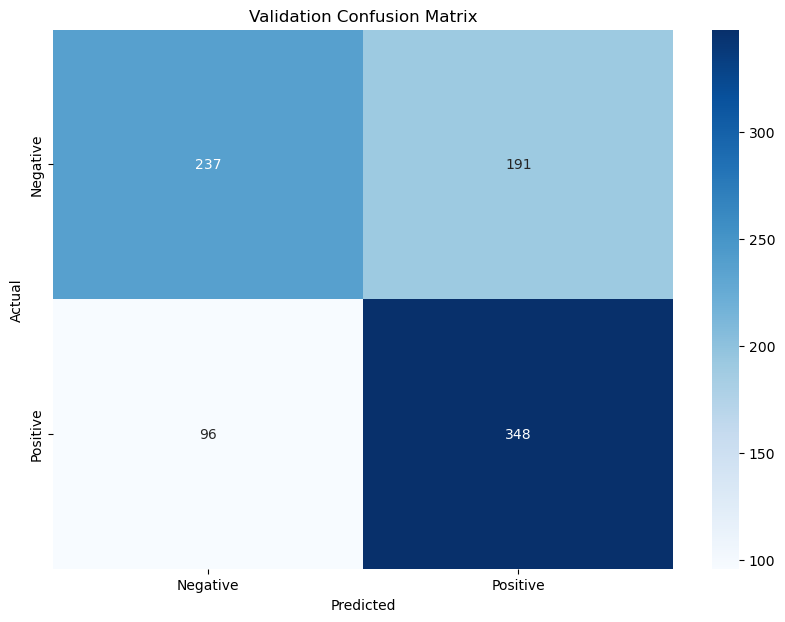

In [18]:

# Train a logistic regression model on training data using Word2Vec embeddings
classifier = LogisticRegression(max_iter=1000)
classifier.fit(list(X_word2vec_train), y_word2vec_train)

# Make predictions on validation set to tune hyperparameters (if needed)
y_word2vec_val_pred = classifier.predict(list(X_word2vec_val))

# Generate classification report and confusion matrix for validation set
print("Validation Classification Report:")
print(classification_report(y_word2vec_val, y_word2vec_val_pred))

val_conf_matrix = confusion_matrix(y_word2vec_val, y_word2vec_val_pred)

# Plotting confusion matrix for validation set
plt.figure(figsize=(10,7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()

Test Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.55      0.62       428
           1       0.65      0.78      0.71       444

    accuracy                           0.67       872
   macro avg       0.68      0.67      0.67       872
weighted avg       0.68      0.67      0.67       872



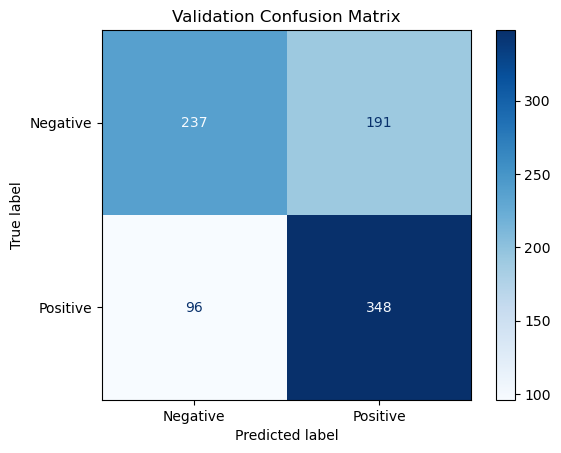

In [19]:
y_word2vec_val_pred = classifier.predict(list(X_word2vec_val))
# Generate classification report and confusion matrix for test set
print("Test Classification Report:")
print(classification_report(y_word2vec_val, y_word2vec_val_pred))

val_conf_matrix = confusion_matrix(y_word2vec_val, y_word2vec_val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=val_conf_matrix, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.show()

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57      1821
           1       0.00      0.00      0.00         0

    accuracy                           0.40      1821
   macro avg       0.50      0.20      0.29      1821
weighted avg       1.00      0.40      0.57      1821



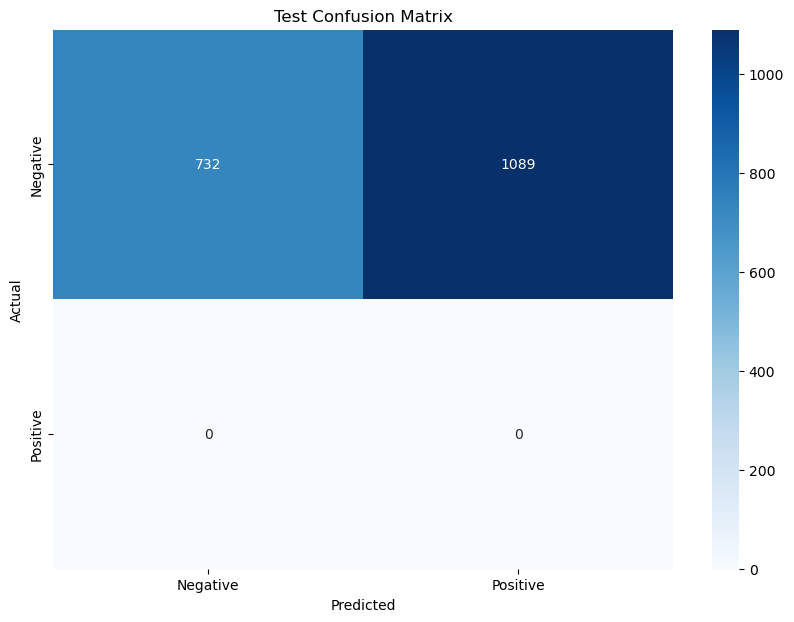

In [49]:
y_word2vec_test_pred = classifier.predict(list(X_word2vec_test))
# Generate classification report and confusion matrix for test set
print("Test Classification Report:")
print(classification_report(y_word2vec_test, y_word2vec_test_pred))

test_conf_matrix = confusion_matrix(y_word2vec_test, y_word2vec_test_pred)

# Plotting confusion matrix for test set
plt.figure(figsize=(10,7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Test Confusion Matrix')
plt.show()

In [21]:
# Check unique values in y_test and y_test_pred
print("Unique values in y_test:", np.unique(y_word2vec_test))
print("Unique values in y_test_pred:", np.unique(y_word2vec_test_pred))

Unique values in y_test: [0]
Unique values in y_test_pred: [0 1]


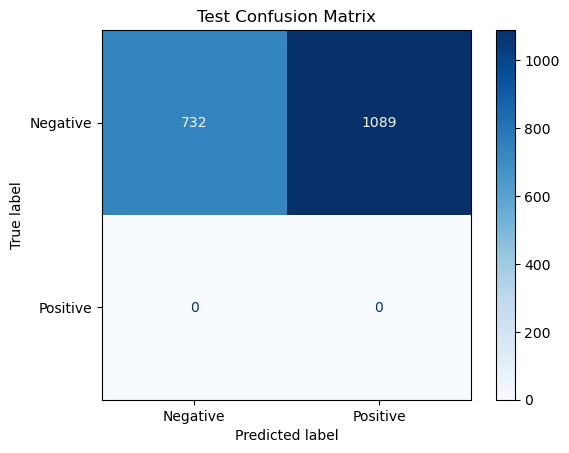

In [22]:
# Now evaluate on test set
y_word2vec_test_pred = classifier.predict(list(X_word2vec_test))
# Generate and plot confusion matrix using ConfusionMatrixDisplay
test_conf_matrix = confusion_matrix(y_word2vec_test, y_word2vec_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Test Confusion Matrix')
plt.show()

## 2. TF-IDF: (Term Frequency-Inverse Document Frequency)

In [23]:
def evaluate_classifier(X_train, X_val, X_test, y_train, y_val, y_test):
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(X_train, y_train)
    
    # Predictions on validation set
    y_val_pred = classifier.predict(X_val)
    
    # Predictions on test set
    y_test_pred = classifier.predict(X_test)
    
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))
    
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=val_conf_matrix, display_labels=['Negative', 'Positive'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Validation Confusion Matrix')
    plt.show()
    
    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred))

    # Generate and plot confusion matrix using ConfusionMatrixDisplay
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=['Negative', 'Positive'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Test Confusion Matrix')
    plt.show()

In [24]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_tfidf_train = tfidf_vectorizer.fit_transform(sst_df_train['sentence'])
X_tfidf_val = tfidf_vectorizer.transform(sst_df_val['sentence'])
X_tfidf_test = tfidf_vectorizer.transform(sst_df_test['sentence'])

In [25]:
X_tfidf_train.shape

(67349, 13774)

In [26]:
X_tfidf_train.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Evaluating TF-IDF:
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       428
           1       0.80      0.87      0.83       444

    accuracy                           0.82       872
   macro avg       0.83      0.82      0.82       872
weighted avg       0.83      0.82      0.82       872



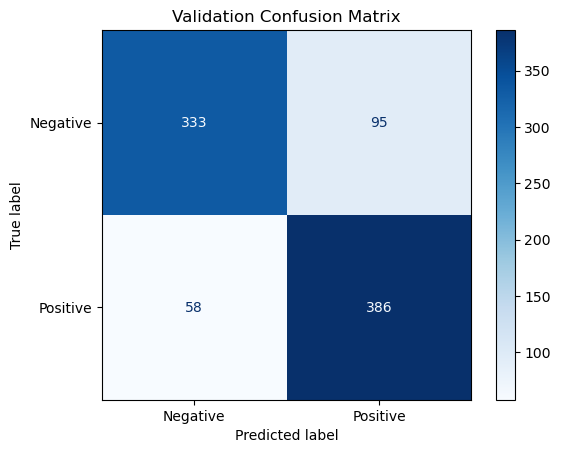

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.46      0.63      1821
           1       0.00      0.00      0.00         0

    accuracy                           0.46      1821
   macro avg       0.50      0.23      0.31      1821
weighted avg       1.00      0.46      0.63      1821



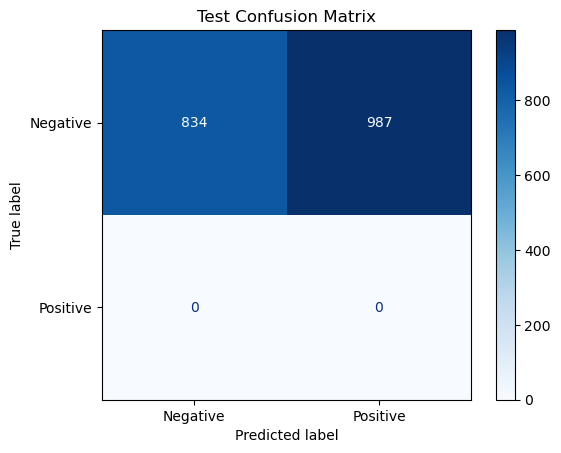

In [27]:
# Prepare labels for training and testing sets
y_tfidf_train = sst_df_train['label'].values  # Assuming 'label' is the target column
y_tfidf_val = sst_df_val['label'].values
y_tfidf_test = sst_df_test['label'].values

# Evaluate each vectorization technique
print("Evaluating TF-IDF:")
evaluate_classifier(X_tfidf_train.toarray(), X_tfidf_val.toarray(), 
                    X_tfidf_test.toarray(), y_tfidf_train, 
                    y_tfidf_val, y_tfidf_test)

## 3. GloVe: (Global Vectors for Word Repersentation)

In [29]:
# Load GloVe vectors from .txt file
def load_glove_vectors(glove_file):
    glove_vectors = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove_vectors[word] = vector
    return glove_vectors

# Load GloVe model (adjust the path accordingly)
glove_file_path = 'datasets/nlp_pre_trained_word_embeddings/glove.6b/glove.6B.100d.txt'  # Replace with your actual path
glove_model = load_glove_vectors(glove_file_path)

# Function to get GloVe embeddings by averaging word vectors
def get_glove_embeddings(sentences):
    embeddings = []
    for sentence in sentences:
        words = sentence.split()
        # Check if there are any valid words in the sentence
        valid_word_vectors = [glove_model[word] for word in words if word in glove_model]
        # Use np.mean on valid_word_vectors if not empty, otherwise use zero vector
        if valid_word_vectors:
            vector = np.mean(valid_word_vectors, axis=0)
        else:
            vector = np.zeros(100)  # Use 100 for GloVe 6B 100d
        embeddings.append(vector)
    return np.array(embeddings)

# Example usage with your DataFrame (replace sst_df_train, sst_df_val, sst_df_test with your actual DataFrames)
# Assuming these DataFrames have a 'sentence' column containing the text data
X_glove_train = get_glove_embeddings(sst_df_train['sentence'])
X_glove_val = get_glove_embeddings(sst_df_val['sentence'])
X_glove_test = get_glove_embeddings(sst_df_test['sentence'])

In [30]:
# Prepare labels for training and testing sets
y_glove_train = sst_df_train['label'].values  # Assuming 'label' is the target column
y_glove_val = sst_df_val['label'].values
y_glove_test = sst_df_test['label'].values

In [31]:
X_glove_train

array([[ 0.14057828, -0.0689643 ,  0.31311712, ..., -0.30055001,
         0.55530399, -0.11383305],
       [-0.11907417,  0.34638432,  0.46991   , ..., -0.7022714 ,
         0.24392144,  0.44225171],
       [ 0.05421834,  0.40184   ,  0.55413431, ..., -0.70558167,
         0.41836295,  0.4024241 ],
       ...,
       [-0.06550364,  0.11493463,  0.37917092, ..., -0.16989733,
         0.50776052,  0.21899208],
       [-0.25291666,  0.16351867,  0.27893665, ..., -0.48581001,
         0.35243669, -0.09040666],
       [-0.15989739,  0.03182573,  0.53505898, ..., -0.36585104,
         0.57373714,  0.16234086]])

Evaluating GloVe:
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       428
           1       0.74      0.81      0.77       444

    accuracy                           0.76       872
   macro avg       0.76      0.76      0.76       872
weighted avg       0.76      0.76      0.76       872



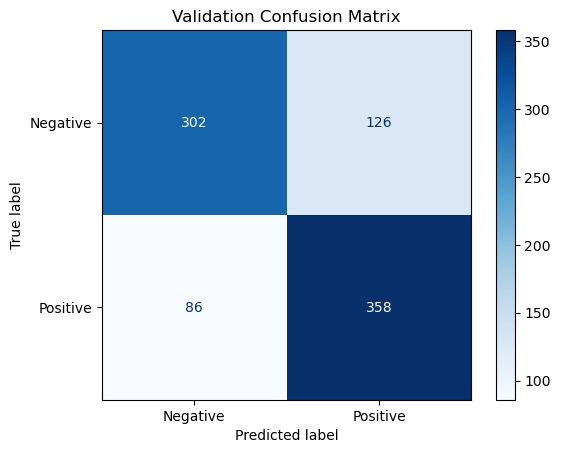

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.44      0.61      1821
           1       0.00      0.00      0.00         0

    accuracy                           0.44      1821
   macro avg       0.50      0.22      0.31      1821
weighted avg       1.00      0.44      0.61      1821



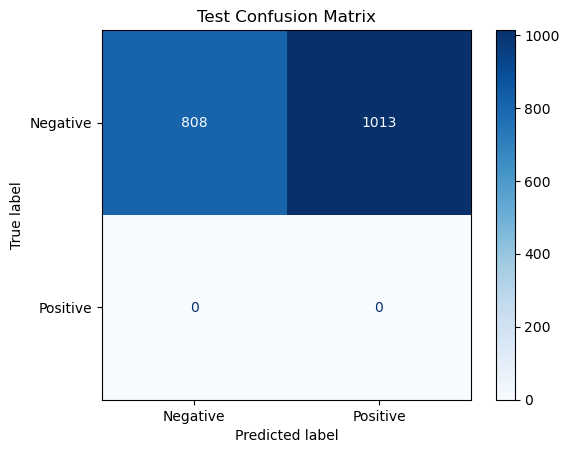

In [32]:
# Evaluate GloVe embeddings
print("Evaluating GloVe:")
evaluate_classifier(X_glove_train, X_glove_val, X_glove_test, y_glove_train, y_glove_val, y_glove_test)

## 4. FastText:

In [33]:
# Train FastText model on training sentences or load pre-trained FastText model
fasttext_model = FastText(sentences=[s.split() for s in sst_df_train['sentence']], vector_size=100, window=5, min_count=1)

def get_fasttext_embeddings(sentences):
    embeddings = []
    for sentence in sentences:
        words = sentence.split()
        vector = np.mean([fasttext_model.wv[word] for word in words if word in fasttext_model.wv], axis=0)
        embeddings.append(vector if len(vector) > 0 else np.zeros(fasttext_model.vector_size))
    return np.array(embeddings)

X_fasttext_train = get_fasttext_embeddings(sst_df_train['sentence'])
X_fasttext_val = get_fasttext_embeddings(sst_df_val['sentence'])
X_fasttext_test = get_fasttext_embeddings(sst_df_test['sentence'])

In [34]:
X_fasttext_train

array([[-0.09900681,  0.61897665, -0.53061193, ..., -0.68235385,
         0.21843539,  0.6284152 ],
       [ 0.44336253, -0.18279196, -0.39648813, ...,  0.2669016 ,
        -0.81402403, -0.3930644 ],
       [-0.36770222,  0.3116452 , -0.988633  , ...,  0.10527734,
        -0.4290669 ,  0.16434866],
       ...,
       [ 0.54108226,  0.17850256, -0.67933756, ..., -0.2338989 ,
        -0.19485734, -0.00552966],
       [ 0.06955618,  0.20476668, -0.44519624, ..., -0.5201902 ,
         0.71402806,  0.16492528],
       [ 0.10446029,  0.18484515, -0.33351475, ..., -0.37506506,
         0.15374205,  0.07846995]], dtype=float32)

In [35]:
X_fasttext_train.shape

(67349, 100)

In [36]:
# Prepare labels for training and testing sets
y_fasttext_train = sst_df_train['label'].values  # Assuming 'label' is the target column
y_fasttext_val = sst_df_val['label'].values
y_fasttext_test = sst_df_test['label'].values

Evaluating FastText:
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.54      0.61       428
           1       0.64      0.79      0.71       444

    accuracy                           0.67       872
   macro avg       0.67      0.66      0.66       872
weighted avg       0.67      0.67      0.66       872



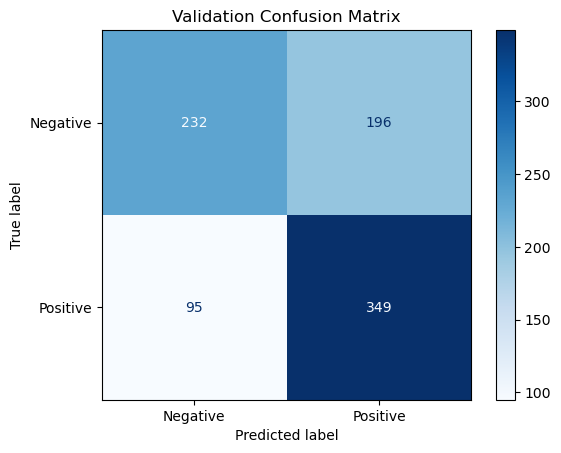

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.38      0.55      1821
           1       0.00      0.00      0.00         0

    accuracy                           0.38      1821
   macro avg       0.50      0.19      0.28      1821
weighted avg       1.00      0.38      0.55      1821



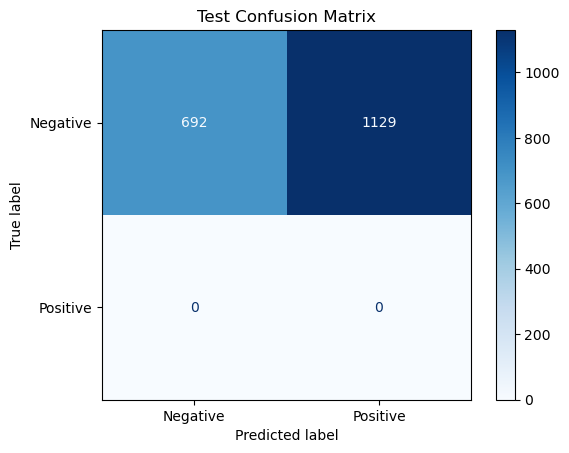

In [37]:
# Evaluate FastText embeddings
print("Evaluating FastText:")
evaluate_classifier(X_fasttext_train, X_fasttext_val, X_fasttext_test, y_fasttext_train, y_fasttext_val, y_fasttext_test)

## 5. Bag Of Words:

In [38]:
# Function to implement Bag of Words using CountVectorizer
def create_bow_features(train_sentences, val_sentences, test_sentences):
    vectorizer = CountVectorizer()
    X_bow_train = vectorizer.fit_transform(train_sentences)
    X_bow_val = vectorizer.transform(val_sentences)
    X_bow_test = vectorizer.transform(test_sentences)
    return X_bow_train, X_bow_val, X_bow_test, vectorizer.vocabulary_

In [39]:
sst_df_train

,idx,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...,...
67344,67344,a delightful comedy,1
67345,67345,"anguish , anger and frustration",0
67346,67346,"at achieving the modest , crowd-pleasing goals...",1
67347,67347,a patient viewer,1


In [40]:
# Create Bag of Words representation
X_bow_train, X_bow_val, X_bow_test, bow_vocab = create_bow_features(
    sst_df_train['sentence'],
    sst_df_val['sentence'],
    sst_df_test['sentence']
)

In [41]:
print("Bag of Words Matrix (Train):\n", X_bow_train.toarray())

Bag of Words Matrix (Train):
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [42]:
X_bow_train.shape

(67349, 13774)

In [43]:
X_bow_test.shape

(1821, 13774)

In [44]:
X_bow_val.shape

(872, 13774)

In [45]:
# Prepare labels for training and testing sets
y_bow_train = sst_df_train['label'].values  # Assuming 'label' is the target column
y_bow_val = sst_df_val['label'].values
y_bow_test = sst_df_test['label'].values

In [46]:
y_bow_train.shape

(67349,)

In [47]:
y_bow_test.shape

(1821,)

Evaluating Bag of Words:
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       428
           1       0.80      0.86      0.83       444

    accuracy                           0.82       872
   macro avg       0.82      0.82      0.82       872
weighted avg       0.82      0.82      0.82       872



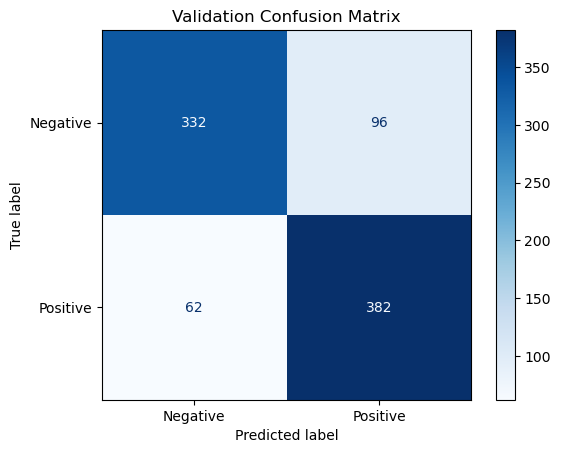

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.47      0.64      1821
           1       0.00      0.00      0.00         0

    accuracy                           0.47      1821
   macro avg       0.50      0.23      0.32      1821
weighted avg       1.00      0.47      0.64      1821



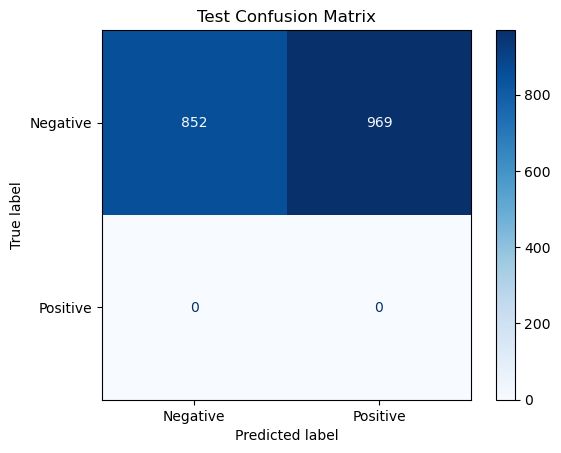

In [48]:
# Evaluate Bag of Words embeddings
print("Evaluating Bag of Words:")
evaluate_classifier(X_bow_train, X_bow_val, X_bow_test, y_bow_train, y_bow_val, y_bow_test)

## Detailed Explanation of Techniques:
 
 - **Word2Vec:** This technique uses neural networks to learn embeddings that reflect semantic relationships based on context. It can be trained using two architectures: Continuous Bag of Words (CBOW) or Skip-Gram.
GloVe: Unlike Word2Vec, which uses local context windows, GloVe captures global statistical information by factorizing a matrix of word co-occurrences.

  - **TF-IDF:** This method builds on BoW by calculating how important a word is to a document relative to its frequency across all documents. It helps reduce the weight of common words that may not be informative.

  - **FastText:** This method improves upon Word2Vec by considering subword information (character n-grams), which allows it to generate embeddings for words not seen during training.

  - **Bag of Words:** This method creates a sparse matrix where each row represents a document and each column represents a unique word from the corpus. The values are counts of how often each word appears in each document.

These techniques collectively enhance our ability to analyze and understand text data semantically and contextually, enabling more effective natural language processing applications.